In [1]:
cd ../pytorch/

/Users/trentonbricken/protein-gen/pytorch


Here I develop different metrics to assess a generated model against the natural sequences, this allows for the discovery of how much diversity the generated model found. 


## Loading in model and setting protein length

In [2]:
import numpy as np
import matplotlib
import platform
if platform.system() == 'Darwin':
    matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch
import datetime

import time
import pickle
import os

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

import seaborn as sns
import matplotlib.pylab as plt
from scipy.special import softmax
import json

from EVCouplingsGen import *
from evcouplings.couplings import CouplingsModel
from EVCouplingsStuff.seq_sele import *

from metropolis import MetropolisHastings
from utils import *

from nflib.MADE import *
from nflib.flows import *
from nflib.spline_flows import NSF_AR, NSF_CL
import itertools

In [3]:
protein_length =154
is_discrete = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading in EVCouplings model 
focus_seqs = read_fa('EVCouplingsStuff/DYR_ECOLI_1_b0.5.a2m_trimmed.fa')
evc_model = CouplingsModel('EVCouplingsStuff/DYR.model')

# extracting the model parameters used to determine the evolutionary hamiltonian
h = evc_model.h_i
J = evc_model.J_ij
print('actual protein length', h.shape)
if protein_length > 0:
    h = h[0:protein_length, :]
    J = J[0:protein_length, 0:protein_length, :,:]

# processing and plotting the natural sequences: 
# first by converting amino acids into integers and also onehots. 
enc_seqs=[]
oh = []
AA=h.shape[1] # number of amino acids
for seq in focus_seqs['seq']:
    enc_seq = np.asarray(encode_aa(seq, evc_model.alphabet_map))
    if protein_length > 0: 
        enc_seq = enc_seq[:protein_length]
    enc_seqs.append(enc_seq) 
    oh.append(onehot(enc_seq,AA)) # this could be made much more efficient with tensorflow operations. 
enc_seqs = np.asarray(enc_seqs)
oh=np.asarray(oh) # of shape: [batch x L x AA]
N = oh.shape[0] # batch size
L = oh.shape[1] # length of the protein

print('number and dimensions of the natural sequences', oh.shape)

# loading in the environment class, used to score the evolutionary hamiltonians
gen_model = EVCouplingsGenerator(L, AA, h, J, device, True, gaussian_cov_noise = 10.0)



actual protein length (155, 20)
number and dimensions of the natural sequences (7848, 154, 20)


Plotting a hist of all the natural sequences energies:


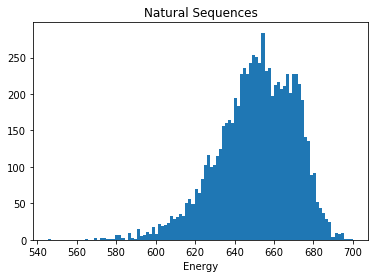

In [4]:
nat_energies = hamiltonians(oh, J, h)
%matplotlib inline
plt.figure()

print('Plotting a hist of all the natural sequences energies:')
plt.hist(nat_energies, bins=100)
plt.title('Natural Sequences')
plt.xlabel('Energy')
plt.gcf().savefig('../notebooks/figs/NatSeqs_FullLen.png', dpi=250)
plt.show()

In [5]:
np.max(nat_energies)

699.9217262584789

## Running MCMC

In [37]:
bolt_gen_model = EVCouplingsGenerator(L, AA, h, J, 
                                      device, False, 
                                      gaussian_cov_noise = 10.0)

shape of feature map torch.Size([20, 3])


In [22]:
high_ind = np.argsort(-nat_energies)
high_seqs = oh[high_ind][:64]
high_seqs = high_seqs.reshape(high_seqs.shape[0], -1)

In [23]:
high_seqs.shape

(64, 3080)

In [24]:

import time
start = time.time()
nsteps = 3000
sampler = MetropolisHastings(bolt_gen_model, noise=5.0, 
                     stride=5, mapper=None, 
                     is_discrete=True, AA_num=AA, x0=high_seqs)
#mapper=HardMaxMapper() but now I have discrete actions so dont need. 
mcmc_x = sampler.run(nsteps)
print(time.time() - start)

28.65997314453125


In [25]:
mcmc_x.shape

(38400, 3080)

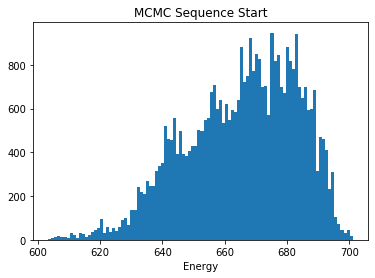

In [26]:
mcmc_hard_energy = hamiltonians(mcmc_x, J, h)
%matplotlib inline
plt.figure()

plt.hist(mcmc_hard_energy, bins=100)
plt.title('MCMC Sequence Start')
plt.xlabel('Energy')
plt.gcf().savefig('../notebooks/figs/MCMC_FullLen.png', dpi=250)

plt.show()

In [27]:
np.max(mcmc_hard_energy)

701.1223349926804

## Boltzmann

In [38]:

base = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(bolt_gen_model.dim), torch.eye(bolt_gen_model.dim))

flows = [AffineHalfFlow(dim=bolt_gen_model.dim, parity=i%2, nh=32 ,scale=False, block_mask=False) for i in range(4)]
flows.append(AffineConstantFlow(dim=bolt_gen_model.dim, shift=False))

network = NormalizingFlowModel(base, flows, bolt_gen_model)

folder_name = 'TryingStable_Cont_Full_Len_GPU_rand_seed-76_ML_epochs-15000_KL_epochs-10000_learning_rate-0.0005_MLweight-1.0_KLweight-0.2_explore1.0_temperature-1.0_s_time-2020-04-06_08_23_00.132648'

#'TryingStable_Discrete_Full_Len_GPU_rand_seed-50_ML_epochs-15000_KL_epochs-10000_learning_rate-0.0005_MLweight-1.0_KLweight-0.5_explore1.0_temperature-1.0_s_time-2020-04-05_22_29_12.248227'
##'TryingStable_Cont_Len_6_rand_seed-96_ML_epochs-10000_KL_epochs-5000_learning_rate-0.0005_MLweight-1.0_KLweight-0.1_explore1.0_temperature-1.0_s_time-2020-04-05_17_11_27.805919'

#'Cont_Len6_rand_seed-28_ML_epochs-600_KL_epochs-500_learning_rate-0.005_MLweight-1.0_KLweight-0.5_explore1.0_temperature-1.0_s_time-2020-04-05_03_39_04.234456'

#'02_GPU_NICEvsNeuralS_len30_rand_seed-98_ML_epochs-8000_KL_epochs-15000_learning_rate-1e-05_MLweight-1.0_KLweight-1.0_explore1.0_temperature-1.0_s_time-2020-01-17_15_50_58.624611'
#'02_GPU_Analy_rand_seed-25_ML_epochs-1000_KL_epochs-1000_learning_rate-0.0001_MLweight-1.0_KLweight-1.0_explore1.0_temperature-1.0_s_time-2020-01-16_18_46_57.944733'
folder_name = folder_name.replace('/',':')
print(folder_name)

# _KL_
network.flow.load_state_dict(torch.load('experiments/'+folder_name+'/Model_Post_ML_KL_Training.torch', map_location=device))

num_gen = 38400
bolt_x = network.sample_xs(temperature=1.0, num_samples=num_gen).detach().numpy()

TryingStable_Cont_Full_Len_GPU_rand_seed-76_ML_epochs-15000_KL_epochs-10000_learning_rate-0.0005_MLweight-1.0_KLweight-0.2_explore1.0_temperature-1.0_s_time-2020-04-06_08_23_00.132648


In [39]:
bolt_x.shape

(38400, 462)

In [40]:
bolt_hard = bolt_x.reshape( bolt_x.shape[0], bolt_gen_model.L, -1 )
            #print(inp.shape, self.L, type(inp))
            # the decoder assumes that input is of the shape [batch x L x properties]
            

#bolt_hard = np.reshape(bolt_x, (bolt_x.shape[0], bolt_gen_model.L, bolt_gen_model.AA_num ))

bolt_hard = bolt_gen_model.decode( torch.tensor(bolt_hard).float() ).cpu().numpy() # this will return [batch_size x log pdf of AAs.]
bolt_hard = np.argmax(bolt_hard, axis=-1)
bolt_hard = np.reshape(bolt_hard, (bolt_x.shape[0], bolt_gen_model.L ) )



In [41]:
bolt_hard.shape

(38400, 154)

In [42]:
bolt_oh = onehot(bolt_hard, AA)
bolt_oh= bolt_oh.reshape((bolt_oh.shape[0], -1))

bolt_hard_energy = hamiltonians(bolt_oh, J, h)

ArgMax


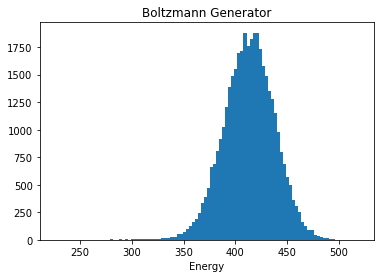

In [43]:
# not the actual energies as this resamples everything!!
#bolt_expec, bolt_hard_energy = network.sample_energy(num_samples=num_gen)

%matplotlib inline
'''plt.figure()

print('Expectation')
plt.hist(bolt_expec, bins=100)
plt.show()'''

plt.figure()

print('ArgMax')
plt.hist(bolt_hard_energy, bins=100)
plt.title('Boltzmann Generator')
plt.xlabel('Energy')
plt.gcf().savefig('../notebooks/figs/Bolt_Joint_FullLen.png', dpi=250)

plt.show()

In [19]:
num_gen

192000

In [108]:
## Running lots of calculations for the average diversity!
import pickle 
from scipy.spatial.distance import hamming, pdist, squareform
n_rand =300
n_rand_iters = 3
num_overall = 5
num_gen = 192000 # for the boltzmann
names = ['Boltzmann', 'MCMC']

top_1000 = pickle.load(open('top_1000_len6.pickle', 'rb'))

results = {'Boltzmann':[], 'Boltzmann_acc':[], 'MCMC_acc':[], 'MCMC':[]}


def hard_max(inp):
    if inp.shape[1] > L: # if it isnt a sequence of ints, then all to .  
        #print('the input to oh is', inp)

        if len(inp)>2:
            inp = inp.reshape(inp.shape[0], -1, 20)
        else:
            inp = inp.reshape(-1,20)

        inp = np.argmax(inp, axis=-1)
    return inp

def accuracy(ground, model):
    # need to increase by one for each it gets wrong to see if it picks up the remainder
    assert len(ground) == len(model)
    wrong = 0
    ind = 0
    model = np.round(model,4)
    ground = list(np.round(ground,4))
    for i in range(len(model)):
        if model[i] not in ground: 
            wrong+=1
            
    return (len(model)-wrong) / len(model)

for j in range(num_overall):
    
    bolt_x = network.sample_xs(temperature=1.0, num_samples=num_gen).detach().numpy()
    print(bolt_x.shape)
    bolt_hard = bolt_x.reshape( bolt_x.shape[0], bolt_gen_model.L, -1 )
            #print(inp.shape, self.L, type(inp))
            # the decoder assumes that input is of the shape [batch x L x properties]
    #bolt_hard = np.reshape(bolt_x, (bolt_x.shape[0], bolt_gen_model.L, bolt_gen_model.AA_num ))
    bolt_hard = bolt_gen_model.decode( torch.tensor(bolt_hard).float() ).cpu().numpy() # this will return [batch_size x log pdf of AAs.]
    bolt_hard = np.argmax(bolt_hard, axis=-1)
    bolt_hard = np.reshape(bolt_hard, (bolt_x.shape[0], bolt_gen_model.L ) )
    
    bolt_oh = onehot(bolt_hard, AA)
    bolt_oh= bolt_oh.reshape((bolt_oh.shape[0], -1))

    bolt_hard_energy = hamiltonians(bolt_oh, J, h)
    #####

    nsteps = 15000
    sampler = MetropolisHastings(bolt_gen_model, noise=5.0, 
                         stride=5, mapper=None, 
                         is_discrete=True, AA_num=AA, x0=high_seqs)
    #mapper=HardMaxMapper() but now I have discrete actions so dont need. 
    mcmc_x = sampler.run(nsteps)
    mcmc_hard = hard_max(mcmc_x)
    mcmc_hard_energy = hamiltonians(mcmc_x, J, h)

    bolt_hard, unq_inds = np.unique(bolt_hard, return_index=True, axis=0)
    bolt_hard_energy = bolt_hard_energy[unq_inds]

    mcmc_hard, unq_inds = np.unique(mcmc_hard, return_index=True, axis=0)
    mcmc_hard_energy = mcmc_hard_energy[unq_inds]
    
    num_samps = 10000

    #TAKING ONLY THE HIGHEST SCORING 10000 SEQUENCES
    inds = np.argsort(-mcmc_hard_energy)
    mcmc_hard = mcmc_hard[inds]
    mcmc_hard_energy = mcmc_hard_energy[inds]

    mcmc_hard = mcmc_hard[:num_samps]
    mcmc_hard_energy = mcmc_hard_energy[:num_samps]
    
    inds = np.argsort(-bolt_hard_energy)
    bolt_hard = bolt_hard[inds]
    bolt_hard_energy = bolt_hard_energy[inds]

    bolt_hard = bolt_hard[:num_samps]
    bolt_hard_energy = bolt_hard_energy[:num_samps]

    for data, n in zip([bolt_hard, mcmc_hard], names):
        print('========= showing! ', n)

        for _ in range(n_rand_iters):

        #print('selecting ', n_rand,' for faster computation')
            rand_inds =np.random.choice(np.arange(data.shape[0]), n_rand, replace=False)
            data = data[rand_inds, :]

            ham = squareform(pdist(data, hamming))

            results[n].append(ham.mean())
            #print(ham.shape)
            #print('mean hamming', ham.mean())
    
    # getting the sequence accuracy
    results['Boltzmann_acc'].append( accuracy(top_1000, bolt_hard_energy[:1000] ) )
    results['MCMC_acc'].append( accuracy(top_1000, mcmc_hard_energy[:1000] ) )


(192000, 18)
========= showing!  Boltzmann
========= showing!  MCMC
(192000, 18)
========= showing!  Boltzmann
========= showing!  MCMC
(192000, 18)
========= showing!  Boltzmann
========= showing!  MCMC
(192000, 18)
========= showing!  Boltzmann
========= showing!  MCMC
(192000, 18)
========= showing!  Boltzmann
========= showing!  MCMC


In [109]:
results;

In [113]:
for k, v in results.items():
    v= np.asarray(v)
    print(k, np.mean(v), np.mean(v)+(np.std(v)*1.96), np.mean(v)-(np.std(v)*1.96))

Boltzmann 0.6980103703703704 0.7080388560399747 0.687981884700766
Boltzmann_acc 0.9301999999999999 0.9434005672605383 0.9169994327394615
MCMC_acc 0.994 0.994 0.994
MCMC 0.6773844444444445 0.6862196463925068 0.6685492424963821


## Quantifying diversity and score metrics

In [44]:
def hard_max(inp):
    if inp.shape[1] > L: # if it isnt a sequence of ints, then all to .  
        #print('the input to oh is', inp)

        if len(inp)>2:
            inp = inp.reshape(inp.shape[0], -1, 20)
        else:
            inp = inp.reshape(-1,20)

        inp = np.argmax(inp, axis=-1)
    return inp

mcmc_hard = hard_max(mcmc_x)
mcmc_hard.shape

(38400, 154)

In [45]:
mcmc_hard

array([[16, 10,  7, ..., 16, 19, 17],
       [16, 10,  7, ..., 16, 19, 16],
       [16,  7,  7, ..., 16, 19,  3],
       ...,
       [11,  1,  7, ..., 17, 19,  3],
       [11, 17,  7, ..., 17, 19,  3],
       [17,  7,  7, ..., 16, 19,  9]])

In [46]:
bolt_hard

array([[ 1,  0, 17, ...,  1, 19, 11],
       [12,  4, 17, ..., 13, 10,  6],
       [12,  7,  7, ..., 10,  4, 17],
       ...,
       [ 1,  4, 17, ...,  6,  4, 12],
       [12, 17, 17, ..., 10, 19,  3],
       [15, 17,  7, ..., 10,  4,  1]])

In [47]:
enc_seqs

array([[15,  9,  7, ...,  7,  9,  3],
       [11,  9, 17, ..., 17, 19,  2],
       [13,  7,  7, ...,  1,  6,  6],
       ...,
       [16,  9,  7, ...,  3, 19,  3],
       [ 1,  9,  7, ..., 17,  4, 13],
       [16,  7,  7, ..., 10,  4,  3]])

In [48]:
enc_seqs, unq_inds = np.unique(enc_seqs, return_index=True, axis=0)
nat_energies = nat_energies[unq_inds]

bolt_hard, unq_inds = np.unique(bolt_hard, return_index=True, axis=0)
bolt_hard_energy = bolt_hard_energy[unq_inds]

mcmc_hard, unq_inds = np.unique(mcmc_hard, return_index=True, axis=0)
mcmc_hard_energy = mcmc_hard_energy[unq_inds]

In [49]:
enc_seqs.shape

(7568, 154)

In [50]:
bolt_hard.shape

(38400, 154)

In [51]:
mcmc_hard.shape

(10474, 154)

In [52]:
n2a = dict([(n, a) for a, n in gen_model.a2n.items()])  
n2a

{0: 'A',
 1: 'C',
 2: 'D',
 3: 'E',
 4: 'F',
 5: 'G',
 6: 'H',
 7: 'I',
 8: 'K',
 9: 'L',
 10: 'M',
 11: 'N',
 12: 'P',
 13: 'Q',
 14: 'R',
 15: 'S',
 16: 'T',
 17: 'V',
 18: 'W',
 19: 'Y'}

In [53]:
def n_to_aa(inp):
    to_aa = []
    N=20 # e of these focus have gaps, else should be 21. 
    for seq in inp:
        st = ''
        for s in seq:
            st+= n2a[s]
        to_aa.append(st)
    to_aa=np.asarray(to_aa)
    return to_aa

In [54]:
# prune parts of the boltzmann 
energy_thresh  = 400

bolt_hard = bolt_hard[bolt_hard_energy > energy_thresh]
bolt_hard_energy = bolt_hard_energy[bolt_hard_energy > energy_thresh]

mcmc_hard = mcmc_hard[mcmc_hard_energy > energy_thresh]
mcmc_hard_energy = mcmc_hard_energy[mcmc_hard_energy > energy_thresh]

In [55]:
bolt_hard.shape

(27386, 154)

In [56]:
mcmc_hard.shape

(10474, 154)

In [57]:
## downsize the x's

num_samps = 10000

#rands = np.random.randint(0, mcmc_hard.shape[0], size=num_samps)
inds = np.argsort(-mcmc_hard_energy)
mcmc_hard = mcmc_hard[inds]
mcmc_hard_energy = mcmc_hard_energy[inds]

mcmc_hard = mcmc_hard[:num_samps]
mcmc_hard_energy = mcmc_hard_energy[:num_samps]
#rands = np.random.randint(0, bolt_hard.shape[0], size=num_samps)
inds = np.argsort(-bolt_hard_energy)
bolt_hard = bolt_hard[inds]
bolt_hard_energy = bolt_hard_energy[inds]

bolt_hard = bolt_hard[:num_samps]
bolt_hard_energy = bolt_hard_energy[:num_samps]
#energy_x = energy_x[inds]

Boltzmann Generator


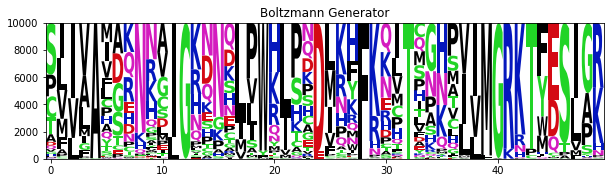

MCMC


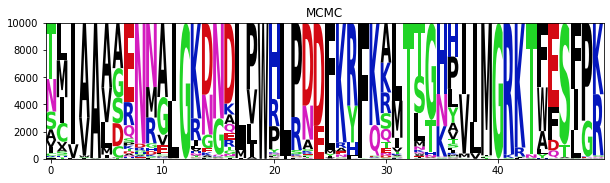

Natural Sequences


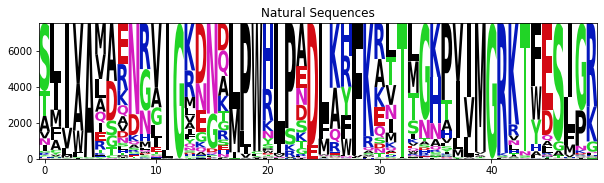

In [59]:
import logomaker as lm
names = ['Boltzmann Generator', 'MCMC', 'Natural Sequences']
for data, n in zip([bolt_hard, mcmc_hard, enc_seqs], names):
    print(n)
    to_aa = n_to_aa(data)
    counts_mat = lm.alignment_to_matrix(to_aa)
    lm.Logo(counts_mat[0:50])
    plt.title(n)
    plt.gcf().savefig('../notebooks/figs/SeqLogo_'+n.split(' ')[-1]+'_FullLen.png', dpi=250)

    plt.show()

(array([ 549., 1032., 1033., 1290., 1323., 1483., 1344., 1170.,  642.,
         134.]), array([630.80288067, 637.8348261 , 644.86677154, 651.89871697,
        658.9306624 , 665.96260783, 672.99455326, 680.0264987 ,
        687.05844413, 694.09038956, 701.12233499]), <a list of 10 Patch objects>)

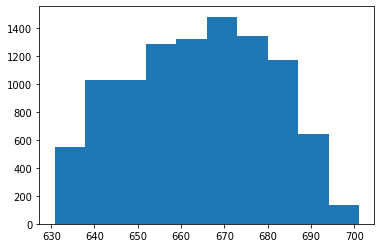

In [60]:
plt.hist(mcmc_hard_energy)

(array([4.158e+03, 2.826e+03, 1.666e+03, 8.320e+02, 3.380e+02, 1.300e+02,
        4.100e+01, 7.000e+00, 1.000e+00, 1.000e+00]),
 array([429.13035462, 438.18510098, 447.23984735, 456.29459371,
        465.34934008, 474.40408644, 483.45883281, 492.51357917,
        501.56832554, 510.6230719 , 519.67781827]),
 <a list of 10 Patch objects>)

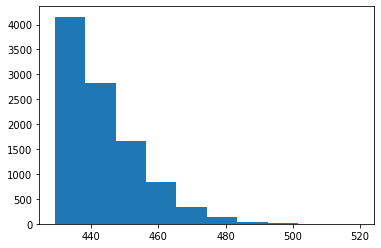

In [61]:
plt.hist(bolt_hard_energy)

In [62]:
# higher the value the further away they are. it is a distance after all

In [63]:
from scipy.spatial.distance import hamming, pdist, squareform
n_rand =100

ham = squareform(pdist(enc_seqs, hamming))
ham.mean()

KeyboardInterrupt: 

========= showing!  Boltzmann Generator
selecting  100  for faster computation
(100, 100)
mean hamming 0.677525974025974


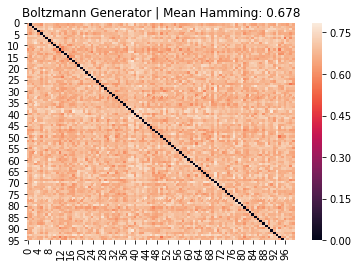

========= showing!  MCMC
selecting  100  for faster computation
(100, 100)
mean hamming 0.5303675324675324


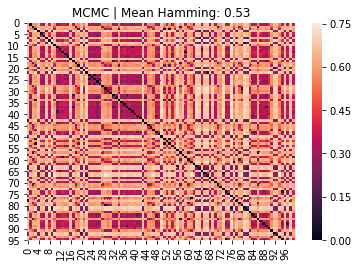

========= showing!  Natural Sequences
selecting  100  for faster computation
(100, 100)
mean hamming 0.6072909090909091


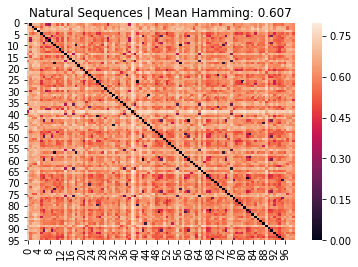

In [64]:
from scipy.spatial.distance import hamming, pdist, squareform
n_rand =100
names = ['Boltzmann Generator', 'MCMC', 'Natural Sequences']

for data, n in zip([bolt_hard, mcmc_hard, enc_seqs], names):
    print('========= showing! ', n)
    
    print('selecting ', n_rand,' for faster computation')
    rand_inds =np.random.choice(np.arange(data.shape[0]), n_rand, replace=False)
    data = data[rand_inds, :]
    
    ham = squareform(pdist(data, hamming))
    print(ham.shape)
    print('mean hamming', ham.mean())
    sns.heatmap(ham)
    plt.title(n +' | Mean Hamming: '+str(round(ham.mean(), 3)))
    plt.gcf().savefig('../notebooks/figs/HammingDist_'+n.split(' ')[-1]+'_Len6.png', dpi=250)

    plt.show()

# Looking at the similarities with MSA weights

In [65]:
enc_seqs[0]

array([ 0,  0,  7, 17,  0, 17, 15, 11, 11,  9, 17,  7,  5, 14, 11, 11,  0,
        9, 12, 18, 19,  9, 12,  3,  2,  9,  8, 19,  4,  8, 13, 17, 16,  9,
        5,  8, 12, 17,  7, 10,  5, 14,  8, 16, 19,  2, 15,  7,  5, 14, 12,
        9, 12,  5, 14,  1, 11,  7, 17,  7, 16,  0, 11, 12, 11, 18, 13,  0,
        5, 17,  8, 17, 17,  6, 15,  9,  0,  0,  0,  7, 15,  9,  0,  3,  0,
        3,  3,  3,  0, 10,  7, 10,  5,  5,  0, 13,  9, 19,  0,  3,  0,  9,
       12, 13, 17,  3, 14,  9, 19,  9, 16, 13, 17,  3,  0,  3, 17,  3,  5,
        2,  0,  4,  4, 12,  0,  9,  2, 18, 13,  6, 18, 13,  9,  9, 13, 13,
       13,  0,  6, 12, 15,  5,  0, 11, 12, 19, 12, 19, 15,  4, 14, 17, 19,
       13])

In [66]:

gen_w, gen_neighbors = msa_weights(bolt_hard, theta=0.8, pseudocount=0) # higher the theta the more closely they need to be related. 
mcmc_w, mcmc_neighbors = msa_weights(mcmc_hard, theta=0.8, pseudocount=0) 
w, neighbors = msa_weights(enc_seqs, theta=0.8, pseudocount=0)

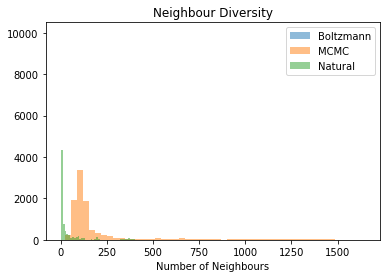

In [67]:

# number of neighours with a hamming above the theta value. 
plt.hist(gen_neighbors, bins=50, alpha=0.5, label='Boltzmann')
plt.hist(mcmc_neighbors, bins=50, alpha=0.5, label='MCMC')
plt.hist(neighbors, bins=50, alpha=0.5, label='Natural')
plt.xlabel('Number of Neighbours')
plt.title('Neighbour Diversity')
plt.gcf().savefig('../notebooks/figs/NeighbourDiversity_Len6.png', dpi=250)

plt.legend()

In [68]:
# combining natural and generated to see what diversity is maintained

comb_gen_nat=  np.concatenate([bolt_hard, mcmc_hard,enc_seqs], axis=0)
w_comb, n_comb = msa_weights(comb_gen_nat, theta=0.5, pseudocount=0)

In [46]:
energy_cut = 20
num_x_kept = x[np.where(energy_x > energy_cut)].shape[0]
print(num_x_kept)
comb_fitgen_nat= np.concatenate([x[np.where(energy_x > energy_cut)], enc_seqs], axis=0)
w_combf, n_combf = msa_weights(comb_fitgen_nat, theta=0.6, pseudocount=0)

fig, ax = plt.subplots(1)
ax.hist(n_combf[:num_x_kept], bins=50, density=True, label='generated');
ax.hist(n_combf[num_x_kept:], bins=50, alpha=0.5, density=True, label='real');
plt.xlabel('number of neighbours')
plt.legend()
plt.show()

NameError: name 'x' is not defined

In [ ]:
gen_w, gen_neighbors = msa_weights(x, theta=0.8, pseudocount=0) # higher the theta the more closely they need to be related. 
w, neighbors = msa_weights(enc_seqs, theta=0.8, pseudocount=0)

In [ ]:
plt.hist(gen_neighbors)

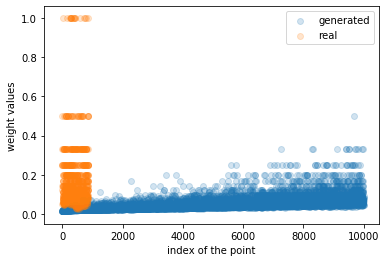

In [47]:
plt.scatter(np.arange(gen_w.shape[0]), gen_w,  alpha=0.2, label='generated')
plt.scatter(np.arange(w.shape[0]), w, alpha=0.2, label='real')
plt.ylabel('weight values')
plt.xlabel('index of the point')
plt.legend()

### UMAP the sequences to see how they cluster

In [70]:
import umap
import seaborn as sns
# sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
reducer = umap.UMAP()

In [71]:
# converting the generated into a onehot: 

bolt_oh = onehot(bolt_hard, AA)
mcmc_oh = onehot(mcmc_hard, AA)
bolt_oh= bolt_oh.reshape((bolt_hard.shape[0], -1))
mcmc_oh= mcmc_oh.reshape((mcmc_hard.shape[0], -1))
bolt_oh.shape

(10000, 3080)

In [72]:
enc_oh = onehot(enc_seqs, AA)
enc_oh= enc_oh.reshape((enc_oh.shape[0], -1))
enc_oh.shape

(7568, 3080)

In [73]:
to_u = np.vstack([bolt_oh, mcmc_oh, enc_oh])
u_type = np.vstack([np.ones((bolt_oh.shape[0], 1))*2,np.ones((mcmc_oh.shape[0], 1)), np.zeros((enc_oh.shape[0], 1))])
print(to_u.shape, u_type.shape)

(27568, 3080) (27568, 1)


In [98]:
reducer.fit(to_u)

/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [99]:
embedding = reducer.transform(to_u)
embedding.shape


(27568, 2)

In [100]:
u_type = list(u_type)
len(u_type)

27568

In [101]:
sns.color_palette()[1]

(1.0, 0.4980392156862745, 0.054901960784313725)

In [102]:
nat_energies.mean()

650.8729491596687

In [103]:
num_gen = bolt_oh.shape[0]
num_gen

10000

In [104]:
to_u.shape

(27568, 3080)

In [105]:
embedding.shape

(27568, 2)

### Generated vs real sequences

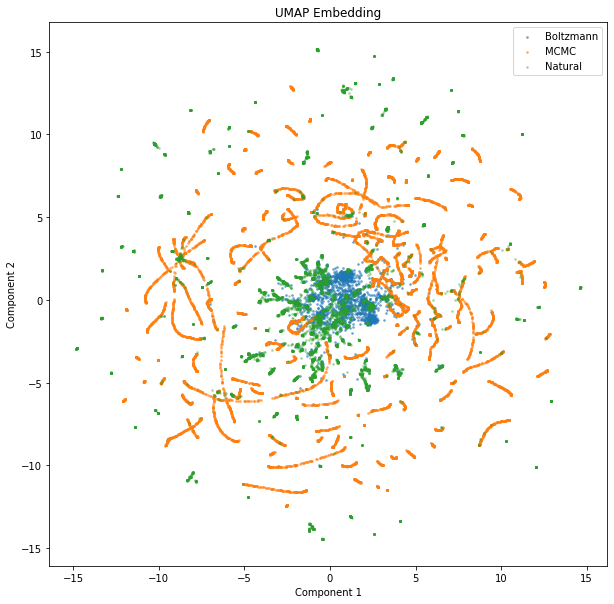

In [106]:
E = 450
#plt.title('UMAP projection of the Generated and Natural Proteins', fontsize=24);
plt.scatter(embedding[0:num_gen, 0][bolt_hard_energy > E], embedding[0:num_gen, 1][bolt_hard_energy > E], s=3, alpha=0.5, label='Boltzmann')
plt.scatter(embedding[num_gen:num_gen*2, 0][mcmc_hard_energy > E], embedding[num_gen:num_gen*2, 1][mcmc_hard_energy > E], s=3, alpha=0.5, label='MCMC')
plt.scatter(embedding[num_gen*2:, 0][nat_energies>E], embedding[num_gen*2:, 1][nat_energies>E], s=3, alpha=0.3, label='Natural')
plt.gcf().set_size_inches(10,10)

plt.title('UMAP Embedding')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.gcf().savefig('../notebooks/figs/UMAP_Cont_Full_rerun.png', dpi=250)
plt.show()

### Scores of the sequences

In [90]:
all_energies = np.hstack([bolt_hard_energy, mcmc_hard_energy,nat_energies])

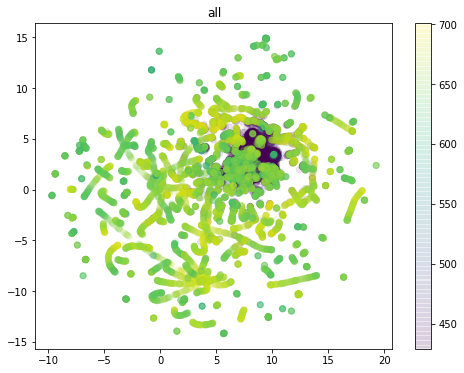

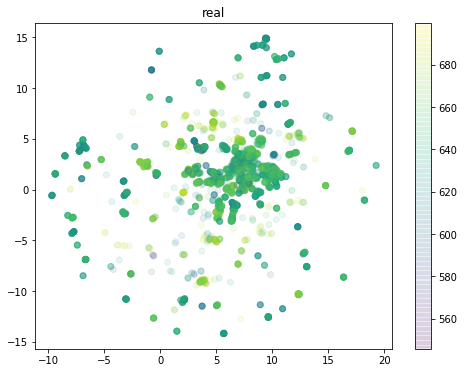

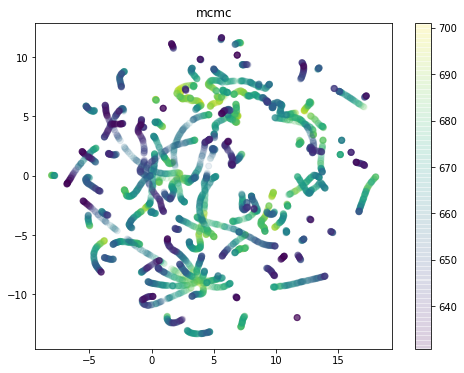

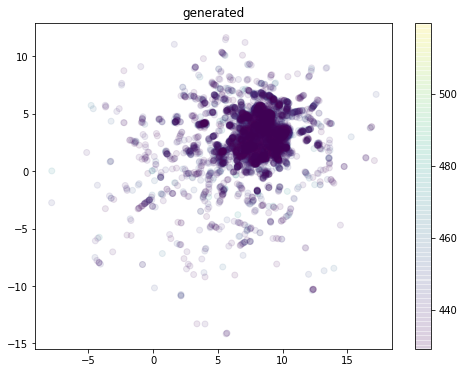

In [97]:
for seqs_and_es_to_plot, title in zip([(embedding, all_energies ), (embedding[num_gen*2:, :], nat_energies),
                                       (embedding[num_gen:num_gen*2, :], mcmc_hard_energy),
                                       (embedding[0:num_gen,:], bolt_hard_energy) ], ['all', 'real', 'mcmc', 'generated']):
    seqs_to_plot, es = seqs_and_es_to_plot
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.scatter(seqs_to_plot[:, 0], seqs_to_plot[:, 1], c=es, alpha=0.1)
    plt.colorbar()
    plt.gcf().savefig('../notebooks/figs/UMAP_Color_Scoring_'+title+'.png', dpi=250)

## Cluster calculation

In [92]:
from ScoreMetricFunctions import *

In [93]:

for hard, energy, name in zip( [bolt_hard, mcmc_hard, enc_seqs], 
                        [bolt_hard_energy, mcmc_hard_energy, nat_energies], ['gen', 'mcmc', 'real']  ):
    print(name)
    E_min = np.min(nat_energies)
    theta = 0.8
    Neff, unique_seqs, unique_peaks, color_clusts = score_diversity_metric(hard, energy, theta, E_min, 
                                                                          calc_Neff=True, color_clusts=True )
    print('theta value:', theta)
    print('Neff:', Neff, 'unique peak num', len(unique_peaks))
    print('unique peak sums', sum(unique_peaks))
    print('================')
    print('================')

gen
theta value: 0.8
Neff: 10000.0 unique peak num 0
unique peak sums 0
mcmc
theta value: 0.8
Neff: 87.09393730172535 unique peak num 1
unique peak sums 701.1223349926804
real
theta value: 0.8
Neff: 2612.0712483197112 unique peak num 1
unique peak sums 699.9217262584789


In [96]:

E_min = np.min(nat_energies)
theta = 0.9
Neff, unique_seqs, unique_peaks, color_clusts = score_diversity_metric(bolt_hard, bolt_hard_energy, theta, E_min, 
                                                                      calc_Neff=True, color_clusts=True )
print('theta value:', theta)
print('Neff:', Neff, 'unique peak num', len(unique_peaks))
print('unique peak sums', sum(unique_peaks))
print('================')
print('================')

theta value: 0.9
Neff: 10000.0 unique peak num 0
unique peak sums 0


In [79]:
unique_peaks

[30.02301879413426, 26.83137374301441, 22.709881007671356, 22.70646969974041]

## UMAP the peaks found. 

In [80]:
to_embed = np.vstack([bolt_hard, np.asarray(unique_seqs)])

In [81]:
x_oh = onehot(to_embed, AA)
x_oh= x_oh.reshape((x_oh.shape[0], -1))
x_oh.shape

(10004, 120)

In [82]:
reducer.fit(x_oh)
embedding = reducer.transform(x_oh)

/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [83]:
cmap = plt.cm.viridis

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

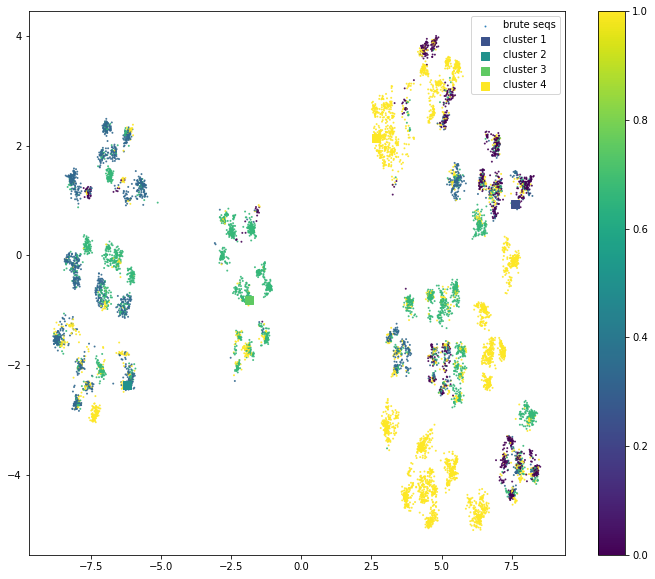

In [84]:
num_peaks = len(unique_seqs)
plt.figure(figsize=(12,10))
plt.scatter(embedding[0:-num_peaks, 0], embedding[0:-num_peaks, 1], s=1, alpha=0.8, c=color_clusts, label='brute seqs')
for i in range(num_peaks):
    plt.scatter(embedding[-num_peaks+i, 0], embedding[-num_peaks+i, 1], c=cmap( (i+1)/num_peaks), s=80, alpha=1.0, marker='s', label='cluster '+str(i+1))
plt.colorbar()
plt.legend()

## What is the list of best sequences for each approach? 

In [102]:
top_100 = np.asarray([30.02301808, 29.54970239, 29.4718494 , 29.21045596, 29.13230475,
       29.00475045, 28.83265807, 28.82473205, 28.66691942, 28.6473012 ,
       28.58873306, 28.56339517, 28.50060317, 28.49537781, 28.47983727,
       28.4572954 , 28.45525953, 28.39082729, 28.34537598, 28.34174599,
       28.29439655, 28.27354554, 28.26573367, 28.265188  , 28.26173751,
       28.25642276, 28.21460162, 28.21404569, 28.19378387, 28.16942112,
       28.1546854 , 28.14671041, 28.12914694, 28.09122565, 28.07172072,
       28.01926645, 27.99531744, 27.97469703, 27.95520729, 27.9307116 ,
       27.92763514, 27.91929987, 27.89478612, 27.88753718, 27.83783934,
       27.83220956, 27.82642138, 27.80075153, 27.79079837, 27.79020024,
       27.72056985, 27.71396668, 27.65081574, 27.63899978, 27.62564814,
       27.62517576, 27.61348347, 27.59438719, 27.58633671, 27.5760056 ,
       27.54543273, 27.54537077, 27.53350744, 27.53048836, 27.52293543,
       27.4865151 , 27.48542588, 27.45325416, 27.45217656, 27.43889303,
       27.42991776, 27.41983225, 27.41940571, 27.41780022, 27.39784222,
       27.39644402, 27.39053458, 27.38622824, 27.38461243, 27.35450897,
       27.32991853, 27.32644977, 27.32173291, 27.31819922, 27.30599787,
       27.29014251, 27.28314669, 27.24976337, 27.24914433, 27.24399346,
       27.24255559, 27.24028615, 27.23240657, 27.22691668, 27.22613323,
       27.21744065, 27.21677776, 27.21017324, 27.20530337, 27.19846435,
       27.19227778, 27.17668372, 27.17587458, 27.17496125, 27.17428619,
       27.1695231 , 27.16705709, 27.1645704 , 27.16285596, 27.15728763,
       27.15589571, 27.14450116, 27.12767757, 27.12241597, 27.1156271 ,
       27.11361124, 27.10663245, 27.10017252, 27.0966853 , 27.09324268,
       27.09153214, 27.08947808, 27.07945311, 27.07551255, 27.06441846,
       27.06227669, 27.06105266, 27.05629539, 27.05329037, 27.05269543,
       27.04872138, 27.04677981, 27.04656172, 27.04105973, 27.03860368,
       27.02582694, 27.02333439, 27.02202361, 27.02158333, 27.02135472,
       27.004716  , 27.004228  , 27.000612  , 26.99440785, 26.99047832,
       26.98463169, 26.97808707, 26.97768658, 26.97107433, 26.96326968,
       26.96032628, 26.95486538, 26.95401274, 26.95024773, 26.94694161,
       26.94160925, 26.93729085, 26.9332967 , 26.92818335, 26.92613077,
       26.92569378, 26.92077643, 26.91701995, 26.90958287, 26.90090362,
       26.8992087 , 26.89854495, 26.89580688, 26.88548138, 26.88005589,
       26.86593943, 26.86435726, 26.85123003, 26.84974847, 26.84196435,
       26.84182366, 26.83394135, 26.83137398, 26.82903551, 26.81430432,
       26.80328005, 26.80323314, 26.80309761, 26.79661329, 26.79185836,
       26.79115968, 26.78671016, 26.77218807, 26.7718228 , 26.77044467,
       26.77033239, 26.76830498, 26.76325298, 26.75575012, 26.75073162,
       26.75058376, 26.74155179, 26.73842075, 26.73719567, 26.73544953,
       26.73128814, 26.72394436, 26.71440993, 26.71152283, 26.70221925,
       26.70209912, 26.69388527, 26.69114539, 26.69062653, 26.69032911,
       26.68722001, 26.6871458 , 26.6741092 , 26.67319748, 26.66774976,
       26.65429119, 26.6512663 , 26.64959789, 26.6421603 , 26.63153072,
       26.6251374 , 26.6239405 , 26.62366097, 26.62338513, 26.62251282,
       26.6204889 , 26.62020257, 26.61725962, 26.61296848, 26.60523773,
       26.60107736, 26.59976602, 26.59955157, 26.59895835, 26.59625384,
       26.59287709, 26.59259   , 26.59172105, 26.58912364, 26.57721079,
       26.57245029, 26.56931157, 26.56325259, 26.55830715, 26.54339743,
       26.53677311, 26.53413978, 26.5309031 , 26.52075884, 26.51971947,
       26.51635143, 26.51511243, 26.50837615, 26.49862252, 26.49380875,
       26.49182301, 26.48807528, 26.48623491, 26.48163126, 26.47588213,
       26.46324377, 26.4631573 , 26.45962151, 26.45757114, 26.45651456,
       26.45569938, 26.44745848, 26.44517811, 26.44385635, 26.44255523,
       26.44099568, 26.43999632, 26.43967842, 26.43576643, 26.42995589,
       26.42656543, 26.42490327, 26.41311429, 26.4068751 , 26.40452655,
       26.39889415, 26.39805708, 26.39723099, 26.39428326, 26.39403048,
       26.39279738, 26.38260875, 26.37890806, 26.37647308, 26.37389581,
       26.37337125, 26.36908119, 26.36832125, 26.36083771, 26.35795214,
       26.34909718, 26.34749392, 26.34262603, 26.34203565, 26.34049332,
       26.32892722, 26.32641975, 26.32085505, 26.31024298, 26.30753153,
       26.29635327, 26.29608131, 26.29386685, 26.29124951, 26.29049371,
       26.28720653, 26.28613019, 26.28382462, 26.28188271, 26.27490857,
       26.26290325, 26.26058261, 26.25755485, 26.2569687 , 26.25639905,
       26.25504712, 26.25306861, 26.25131186, 26.25092204, 26.25064156,
       26.24847885, 26.24754776, 26.24730965, 26.23972682, 26.23832664,
       26.23721726, 26.22773194, 26.2168839 , 26.20750144, 26.20328068,
       26.19907212, 26.19429387, 26.19223512, 26.19111898, 26.18786896,
       26.18278087, 26.16509294, 26.16323191, 26.16232794, 26.161804  ,
       26.16028401, 26.15903987, 26.15834877, 26.15691282, 26.15388691,
       26.15282002, 26.14915303, 26.14347065, 26.13695791, 26.13670331,
       26.13480866, 26.13208721, 26.1310825 , 26.13026368, 26.12953045,
       26.12797631, 26.12740056, 26.12474554, 26.12461712, 26.12399683,
       26.11094593, 26.11018805, 26.1097994 , 26.10871054, 26.1086973 ,
       26.10749675, 26.10235336, 26.09870863, 26.09575792, 26.09530871,
       26.09098372, 26.08875475, 26.08536374, 26.07953922, 26.07667035,
       26.07559207, 26.07535113, 26.07406702, 26.07267401, 26.07184428,
       26.06922457, 26.06751212, 26.06454992, 26.06360005, 26.06057902,
       26.05993345, 26.05964373, 26.05940615, 26.0591317 , 26.05900145,
       26.05826774, 26.05497416, 26.05083875, 26.04812066, 26.04647288,
       26.03957354, 26.03865882, 26.03753868, 26.03566611, 26.03490956,
       26.03353538, 26.03075476, 26.03060502, 26.02821594, 26.02802523,
       26.026707  , 26.02213175, 26.01429066, 26.01202268, 26.01152748,
       26.0094092 , 26.00726301, 26.00682073, 26.00571302, 26.00388125,
       26.00307261, 26.00143248, 25.99993587, 25.99822898, 25.99812892,
       25.99384569, 25.99290283, 25.99097999, 25.98659151, 25.98352152,
       25.98297808, 25.97959404, 25.97632282, 25.97028393, 25.96824313,
       25.96549468, 25.96441268, 25.96370852, 25.96334168, 25.96331207,
       25.9628595 , 25.96279162, 25.96104928, 25.95792772, 25.95339592,
       25.95207235, 25.94908105, 25.94368491, 25.9417518 , 25.94013366,
       25.93910604, 25.93656539, 25.93653331, 25.93529877, 25.93476917,
       25.93396725, 25.92956318, 25.92650431, 25.92632166, 25.92502015,
       25.92489633, 25.92116187, 25.92064371, 25.91863243, 25.91555082,
       25.91427048, 25.91354342, 25.91046979, 25.90856726, 25.9057234 ,
       25.90401156, 25.90337031, 25.90140661, 25.8976584 , 25.89589214,
       25.89294253, 25.89027799, 25.88954412, 25.88592181, 25.88243628,
       25.88195012, 25.88055804, 25.8756557 , 25.87469575, 25.87338967,
       25.87067437, 25.86747177, 25.86628322, 25.8636674 , 25.84726068,
       25.84674012, 25.8432599 , 25.84104533, 25.83953813, 25.83876133,
       25.83730955, 25.83586221, 25.8350284 , 25.82662983, 25.82632897,
       25.82545345, 25.82382952, 25.82369223, 25.8216897 , 25.82132311,
       25.82024108, 25.81812875, 25.81765441, 25.8175209 , 25.81743778,
       25.81591137, 25.81465746, 25.80962834, 25.80929721, 25.80890343,
       25.80800941, 25.80762941, 25.80102646, 25.79965431, 25.79952064,
       25.79451831, 25.79386215, 25.79190966, 25.7907626 , 25.79034219,
       25.78906796, 25.7885545 , 25.78840425, 25.78732981, 25.78621451,
       25.78396653, 25.7818799 , 25.77767798, 25.77727696, 25.77575962,
       25.7740808 , 25.77299309, 25.77178022, 25.77171982, 25.77055242,
       25.77013067, 25.76753772, 25.76458409, 25.76388223, 25.76268318,
       25.75814599, 25.75753127, 25.7522734 , 25.75095816, 25.75074266,
       25.74999713, 25.74959031, 25.74921366, 25.74820414, 25.74350552,
       25.74140784, 25.73853965, 25.72911311, 25.72906961, 25.72722798,
       25.72721166, 25.72589516, 25.72020809, 25.71984843, 25.71451063,
       25.71177999, 25.71159317, 25.71150007, 25.71007082, 25.70746421,
       25.70743955, 25.70445407, 25.70371459, 25.70240358, 25.69836884,
       25.69752204, 25.69750874, 25.69744588, 25.69717049, 25.69138938,
       25.69136918, 25.69071992, 25.6902998 , 25.68978722, 25.68899159,
       25.68781106, 25.68773642, 25.6869537 , 25.6840319 , 25.67812491,
       25.67750392, 25.67461172, 25.67316528, 25.67246451, 25.66733376,
       25.66650967, 25.66567901, 25.66502544, 25.66423012, 25.66389524,
       25.6615437 , 25.66078437, 25.65279391, 25.65055158, 25.65026657,
       25.64986831, 25.64862735, 25.64723716, 25.64611457, 25.6454971 ,
       25.64319655, 25.64103927, 25.63939788, 25.6389481 , 25.6387573 ,
       25.63846848, 25.63784705, 25.63781555, 25.63658185, 25.63392894,
       25.63372715, 25.63358437, 25.63297804, 25.63020387, 25.6298947 ,
       25.62616217, 25.62600325, 25.62591638, 25.62311194, 25.62148759,
       25.61930128, 25.61796171, 25.61588385, 25.61474155, 25.61373997,
       25.61236051, 25.6119546 , 25.61079759, 25.60885743, 25.60772569,
       25.60710451, 25.6050653 , 25.60452522, 25.60195353, 25.60139755,
       25.60121633, 25.6001093 , 25.5989123 , 25.59810596, 25.5980375 ,
       25.59469237, 25.59269834, 25.59247316, 25.59127072, 25.58731977,
       25.58718895, 25.58450935, 25.58447109, 25.58429445, 25.58187174,
       25.57920756, 25.57920434, 25.57734125, 25.57733469, 25.57154359,
       25.5676333 , 25.56759208, 25.56300682, 25.55929688, 25.55756662,
       25.55636764, 25.55556403, 25.55424222, 25.55321898, 25.55207489,
       25.55160754, 25.55159353, 25.54693254, 25.54647098, 25.54503456,
       25.54234631, 25.54230544, 25.54190055, 25.53985825, 25.53591564,
       25.53356033, 25.53085987, 25.5307443 , 25.53069493, 25.53016962,
       25.5299526 , 25.52951289, 25.52930637, 25.52794403, 25.52226182,
       25.52215297, 25.52198666, 25.51960593, 25.51776073, 25.51610017,
       25.51446663, 25.5138998 , 25.50950292, 25.50726361, 25.50603789,
       25.50585873, 25.50480947, 25.50344861, 25.50275756, 25.50122577,
       25.5003679 , 25.50035804, 25.49864874, 25.49822533, 25.49769177,
       25.49724646, 25.49418718, 25.49310343, 25.49171657, 25.49105713,
       25.49032298, 25.49011154, 25.4888707 , 25.48869103, 25.48754907,
       25.48713027, 25.48647882, 25.48448247, 25.48432134, 25.48025682,
       25.47905515, 25.47807173, 25.47705885, 25.47562468, 25.47524337,
       25.47410042, 25.4690818 , 25.46764658, 25.46744291, 25.46731267,
       25.46643589, 25.46610993, 25.46592971, 25.4631417 , 25.46286515,
       25.45979613, 25.45878901, 25.45555688, 25.45229687, 25.45056921,
       25.44967615, 25.448693  , 25.44373268, 25.44340115, 25.44036999,
       25.43886598, 25.43810042, 25.43749038, 25.4362563 , 25.43531654,
       25.43436171, 25.43362241, 25.42917824, 25.42897489, 25.42855639,
       25.4285499 , 25.42755975, 25.42730707, 25.42649297, 25.42621717,
       25.42582453, 25.42457406, 25.42051285, 25.41871388, 25.41867268,
       25.41756013, 25.41705835, 25.41488162, 25.41409691, 25.41325138,
       25.41292223, 25.41142108, 25.41126962, 25.410705  , 25.40991318,
       25.40783616, 25.40628604, 25.40521952, 25.40493991, 25.4048508 ,
       25.40402616, 25.40120569, 25.4011979 , 25.40022978, 25.39857084,
       25.39824989, 25.39752258, 25.39699819, 25.3961154 , 25.39471608,
       25.39404862, 25.38836973, 25.38670145, 25.3857717 , 25.38238187,
       25.38162226, 25.3813228 , 25.37606934, 25.37461255, 25.3743198 ,
       25.37430313, 25.37250894, 25.37227287, 25.37220455, 25.36848784,
       25.36772221, 25.36459895, 25.36423671, 25.36411304, 25.36050579,
       25.35978211, 25.35913469, 25.35773591, 25.3525988 , 25.35220032,
       25.35199457, 25.35159012, 25.34968046, 25.34892663, 25.34737496,
       25.34522536, 25.34268848, 25.34096645, 25.33895196, 25.33870456,
       25.33686354, 25.33404074, 25.333265  , 25.33069639, 25.33037517,
       25.33018342, 25.32955214, 25.32748058, 25.3270769 , 25.32609148,
       25.32539973, 25.32194893, 25.32078648, 25.31938895, 25.31905323,
       25.31892016, 25.31746353, 25.314986  , 25.31444303, 25.31262004,
       25.31221117, 25.3105595 , 25.31019651, 25.30946715, 25.30696077,
       25.3055546 , 25.30436323, 25.30194889, 25.30151062, 25.30090839,
       25.30087306, 25.29874633, 25.29729112, 25.29530201, 25.29516609,
       25.29352139, 25.29318436, 25.29255482, 25.29154834, 25.28901575,
       25.28850888, 25.28746174, 25.28543807, 25.28479499, 25.28013801,
       25.27970496, 25.27947996, 25.27881663, 25.27870356, 25.27490253,
       25.27464312, 25.271473  , 25.26821292, 25.26401866, 25.26368248,
       25.26222398, 25.26073764, 25.25906269, 25.2568656 , 25.25663499,
       25.2559825 , 25.25597803, 25.2540603 , 25.25121826, 25.24996215,
       25.24977555, 25.24961113, 25.24907057, 25.24904727, 25.24800048,
       25.24704163, 25.24667409, 25.24561034, 25.24201327, 25.24186313,
       25.24049469, 25.23984349, 25.23846557, 25.23714809, 25.23426383,
       25.23302456, 25.23106333, 25.23083068, 25.22866482, 25.2265452 ,
       25.22611961, 25.22560556, 25.22523352, 25.22433893, 25.22271508,
       25.2222225 , 25.22222165, 25.22015752, 25.21821681, 25.21680797,
       25.21559807, 25.21546811, 25.21526191, 25.21512351, 25.21405002,
       25.21308214, 25.2129883 , 25.21169336, 25.2091926 , 25.20863297,
       25.20773312, 25.20687266, 25.20592049, 25.20514936, 25.20315688,
       25.19988874, 25.19941079, 25.19927565, 25.19763077, 25.19549711,
       25.19387226, 25.19252754, 25.19091918, 25.19046902, 25.18966245,
       25.18883002, 25.18859435, 25.18761008, 25.18546906, 25.18114454,
       25.17883195, 25.17566917, 25.17435709, 25.17430584, 25.17321238,
       25.17157111, 25.17125629, 25.16968814, 25.16880862, 25.16675288,
       25.16596692, 25.1659458 , 25.16407579, 25.16344   , 25.16238669,
       25.16081123, 25.15974519, 25.15946919, 25.15843603, 25.15781533,
       25.15690654, 25.15622186, 25.15471839, 25.15356711, 25.15279657,
       25.15160922, 25.15086529, 25.14998436, 25.14568114, 25.14547196,
       25.14339258, 25.14191621, 25.14164875, 25.14107061, 25.13861087,
       25.13815225, 25.13712568, 25.13392823, 25.13249722, 25.12986572])

In [103]:
import pickle 
pickle.dump(top_100, open('top_1000_len6.pickle', 'wb'))

In [86]:
np.round(energy[0:4],5)

array([26.57721, 18.50653, 25.90572, 21.69946])

In [87]:
df = dict()
top_num = 10

def accuracy(ground, model):
    # need to increase by one for each it gets wrong to see if it picks up the remainder
    assert len(ground) == len(model)
    wrong = 0
    ind = 0
    model = np.round(model,4)
    ground = list(np.round(ground,4))
    for i in range(len(model)):
        if model[i] not in ground: 
            wrong+=1
            
    return (len(model)-wrong) / len(model)
        


for seqs, energy, name in zip( [bolt_hard, mcmc_hard, enc_seqs], 
                        [bolt_hard_energy, mcmc_hard_energy, nat_energies], ['gen', 'mcmc', 'real']  ):
    
    seqs, unq_inds = np.unique(seqs, return_index=True, axis=0)
    energy = energy[unq_inds]
    sort_ind = np.argsort(-energy)
    energy = energy[sort_ind]
    seqs = seqs[sort_ind]
    for i in range(top_num):
        df[name+'_seq_'+str(i)] = [seqs[i], energy[i]]
        #df[name+'_energy_'+str(i)] = energy[i]
        
    if name =='real': 
        print(name, 'accuracy is: ', accuracy(top_100[:len(seqs)], energy[:len(seqs)]) )
    else: 
        print(name, 'accuracy is: ', accuracy(top_100, energy[:1000]) )



gen accuracy is:  0.926
mcmc accuracy is:  0.994
real accuracy is:  0.41705069124423966


In [ ]:
len(energy)

In [192]:
df

{'gen_seq_0': [array([15,  9,  7,  0,  0, 17]), 30.02301879413426],
 'gen_seq_1': [array([15,  9,  7, 17,  0, 17]), 29.54970263130963],
 'gen_seq_2': [array([16,  9,  7,  0,  0, 17]), 29.47184963710606],
 'gen_seq_3': [array([15,  7,  7,  0,  0, 17]), 29.21045500971377],
 'gen_seq_4': [array([15,  7,  7, 17,  0, 17]), 29.132307136431336],
 'gen_seq_5': [array([11,  9,  7,  0,  0, 17]), 29.004751170054078],
 'gen_seq_6': [array([15, 10,  7,  0,  0, 17]), 28.83265831321478],
 'gen_seq_7': [array([15,  9,  7,  0,  0,  7]), 28.824733715504408],
 'gen_seq_8': [array([15,  9,  7,  0,  0,  9]), 28.666919777169824],
 'gen_seq_9': [array([15,  9,  7, 17,  0,  0]), 28.647302148863673],
 'mcmc_seq_0': [array([15,  9,  7,  0,  0, 17]), 30.02301879413426],
 'mcmc_seq_1': [array([15,  9,  7, 17,  0, 17]), 29.54970263130963],
 'mcmc_seq_2': [array([16,  9,  7,  0,  0, 17]), 29.47184963710606],
 'mcmc_seq_3': [array([15,  7,  7,  0,  0, 17]), 29.21045500971377],
 'mcmc_seq_4': [array([15,  7,  7, 17, 

In [120]:
import pandas as pd
pd.DataFrame.from_dict(df).T

,0,1
gen_seq_0,"[15, 7, 7, 0, 0, 17]",29.2105
gen_seq_1,"[11, 9, 7, 0, 0, 17]",29.0048
gen_seq_2,"[15, 10, 7, 0, 0, 17]",28.8327
gen_seq_3,"[15, 9, 7, 0, 0, 7]",28.8247
gen_seq_4,"[15, 9, 7, 0, 0, 9]",28.6669
gen_seq_5,"[15, 9, 7, 17, 0, 0]",28.6473
gen_seq_6,"[16, 9, 7, 17, 0, 17]",28.5006
gen_seq_7,"[16, 7, 7, 0, 0, 17]",28.4954
gen_seq_8,"[8, 9, 7, 0, 0, 17]",28.3908
gen_seq_9,"[0, 9, 7, 0, 0, 17]",28.3417


## Reweighting the boltzmann

sampling/analysis def free_energy_bootstrap 
but use the weights for everythinga nd then resample from them after accounting for the logs etc. 

In [26]:
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bin_means, Es = free_energy_bootstrap(sample_x[:, 0], bins=100, nbootstrap=100, log_weights=log_w)

AttributeError: 'NormalizingFlowModel' object has no attribute 'sample'

In [27]:
def seq_counter(seqs, AA=20):
    # assumes not in one hot
    counter = np.zeros((AA, AA))
    for s in seqs: 
        counter[s[0], s[1]] +=1
    return counter

def hist_weights(network):
    sample_x, log_w = network.sample_log_w(temperature=1.0, num_samples=100000)
    log_w -= log_w.max()
    bins = np.linspace(-2.5, 2.5, 100)
    bin_means = (bins[:-1] + bins[1:]) /2
    sample_x_index = np.digitize(sample_x[:, 0], bins)
    whist = np.zeros(len(bins) + 1)
    for i in range(len(log_w)):
        whist[sample_x_index[i]] += np.exp(log_w[i])
    return bin_means, whist[1:-1]

In [132]:
x.shape

NameError: name 'x' is not defined

In [133]:
sample_x, log_w = network.sample_log_w(temperature=1.0, 
                                       num_samples=num_gen)

inp = sample_x.reshape( sample_x.shape[0], gen_model.L, -1 )
sample_x_seqs = bolt_gen_model.decode( torch.tensor(inp).float() ).numpy()
x = sample_x_seqs.argmax(axis=-1)
sample_energies = -bolt_gen_model.energy(sample_x)

log_w -= log_w.max()

counter = seq_counter(x)

# account for how much weight in total is in each bin. 
whist = np.zeros_like(counter)
for i in range(len(log_w)):
    whist[x[i][0], x[i][1]] += np.exp(log_w[i] - log_w.max())

KeyboardInterrupt: 

In [ ]:
len(log_w)

In [ ]:
# now using the weights I need to resample the sequences. 
# get probabilities and then convert these back to scores. 

single_index_dict = dict()
for i in range(counter.shape[0] * counter.shape[1]):
    single_index_dict[i] = np.array( [i//counter.shape[0], i%counter.shape[1]])

whist = whist/whist.sum()

In [ ]:
n_boots = 20
energies = []
for n in range(n_boots):
    rand_inds = np.random.choice( np.arange(len(single_index_dict)), size =x.shape[0], p = whist.flatten(), replace=True )
    rand_seqs = []
    for r in rand_inds:
        rand_seqs.append(single_index_dict[r])
    rand_seqs = np.asarray(rand_seqs)
    rand_counter = seq_counter(rand_seqs)
    rand_counter = rand_counter / rand_counter.sum()
    E = -np.log(rand_counter)
    energies.append(E)
    
energies = np.asarray(energies)


In [72]:
# compute the mean and std! 
emean = energies.mean(axis=0)

In [73]:
# plotting the energies after reweighted bootstrapping
emean = emean - emean[np.isfinite(emean)].min() + sample_energies.min()

In [74]:
top = -emean.flatten()
top = top[np.isfinite(top)].flatten()
top;

In [75]:
emean.shape

(20, 20)